<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2026-1/notebooks/1c_redes_densas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Autor:* Pablo Uriel Benítez Ramírez

# Regresión con redes densas en PyTorch

In [58]:
import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn

# fijamos las semillas de los PRNG por reproducibilidad
np.random.seed(42)
th.manual_seed(42)

T_LOTE = 8

## Conjunto de datos
Se usa el conjunto de datos de regresión Diabetes Dataset con scikit-learn. Este conjunto de datos está compuesto por 442 ejemplos con 10 atributos numéricos y una variable de respuesta.

In [59]:
from sklearn.datasets import load_diabetes

db = load_diabetes(return_X_y=False, as_frame=True)

Revisamos la descripción del conjunto:

In [60]:
print(db.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

Desplegamos los datos:

In [61]:
db['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


Exploramos la distribución de los valores de la variable objetivo:

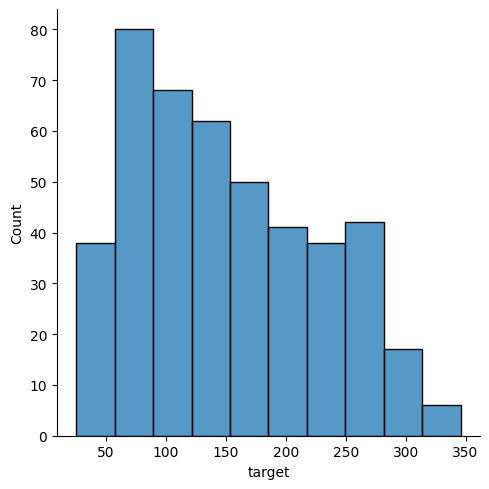

In [62]:
import pandas as pd
import seaborn as sns

sns.displot(db['target'][:])
plt.show()

Dividimos este conjunto en subconjuntos de entrenamiento, validación y prueba usando la función `train_test_split` de scikit-learn.

In [63]:
from sklearn.model_selection import train_test_split

X_ent, X_prueba, y_ent, y_prueba = train_test_split(db['data'].to_numpy(),
                                                    db['target'].to_numpy(),
                                                    test_size = 0.3,
                                                    shuffle=True,
                                                    random_state=42)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent,
                                              y_ent,
                                              test_size = 0.2,
                                              shuffle=True,
                                              random_state=42)

Estandarizamos los valores de los atributos:

In [64]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_ent)

X_ent = sc.transform(X_ent)
X_val = sc.transform(X_val)
X_prueba = sc.transform(X_prueba)

Convertimos los subconjuntos de arreglos de NumPy a instancias de `Tensor` de PyTorch y los cargamos al GPU (si está disponible). Para evitar errores de tipos de datos distintos de los operandos, es importante asegurarse de que coincidan. En esta libreta vamos a trabajar con enteros de 32 bits, por lo que lo especificamos en la función `tensor`.

In [65]:
disp = 'cuda:0' if th.cuda.is_available() else 'cpu'

X_ent = th.tensor(X_ent, dtype = th.float32, device = disp)
X_val = th.tensor(X_val, dtype = th.float32, device = disp)
X_prueba = th.tensor(X_prueba, dtype = th.float32, device = disp)

y_ent = th.tensor(y_ent,  dtype = th.float32, device = disp)
y_val = th.tensor(y_val,  dtype = th.float32, device = disp)
y_prueba = th.tensor(y_prueba, dtype = th.float32,  device = disp)

print(f'Forma de X_ent = {X_ent.shape}, y_ent = {y_ent.shape}')
print(f'Forma de X_val = {X_val.shape}, y_val = {y_val.shape}')
print(f'Forma de X_prueba = {X_prueba.shape}, y_prueba = {y_prueba.shape}')

Forma de X_ent = torch.Size([247, 10]), y_ent = torch.Size([247])
Forma de X_val = torch.Size([62, 10]), y_val = torch.Size([62])
Forma de X_prueba = torch.Size([133, 10]), y_prueba = torch.Size([133])


También es importante asegurarse de que las formas de los tensores de las predicciones (`y_hat`) y de los salidas reales (`y`) sean iguales. Aquí vamos a presuponer que son vectores columnas de $n \times 1$, por lo que cambiamos de forma.

In [66]:
y_ent = y_ent.reshape((y_ent.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_prueba = y_prueba.reshape((y_prueba.shape[0], 1))
print(f'Forma de y_ent = {y_ent.shape}, y_val = {y_val.shape} y_prueba = {y_prueba.shape}')

Forma de y_ent = torch.Size([247, 1]), y_val = torch.Size([62, 1]) y_prueba = torch.Size([133, 1])


Creamos nuestro cargador de datos a partir de los tensores mediante la clase `TensorDataset`.

In [67]:
from torch.utils.data import TensorDataset, DataLoader

entdl = DataLoader(TensorDataset(X_ent, y_ent),
                   batch_size=T_LOTE,
                   shuffle=True,
                   drop_last=True)
valdl = DataLoader(TensorDataset(X_val, y_val),
                   batch_size=T_LOTE,
                   shuffle=False,
                   drop_last=False)
pruebadl = DataLoader(TensorDataset(X_prueba, y_prueba),
                      batch_size=1,
                      shuffle=False,
                      drop_last=False)

## Clase `Module` de `nn`
Muchas de las clases y funciones para definir, entrenar y evaluar redes neuronales están contenidas el módulo `nn` de PyTorch. En particular contamos con la clase [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), una plantilla base para definir los distintos componentes de una arquitectura de red (ver [https://pytorch.org/docs/stable/notes/modules.htm](https://pytorch.org/docs/stable/notes/modules.html)). De hecho, hay varias subclases predefinidas de `Module` asociadas a diversos tipos de capas. Por ej., la subclase [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) representa una capa densa o completamente conectada. Esta subclase tiene como argumentos no opcionales la dimension de los vectores de entrada y el número de neuronas (dimensión de los vectores de salida). Una instancia de `Linear` procesa una matriz de tamaño $n \times \text{in_features}$, la cual multiplica por la transpuesta de una matriz de pesos de $\text{out_features} \times \text{in_features}$ y le suma un vector de sesgos de tamaño $\text{out_features}$

In [68]:
clin = nn.Linear(in_features = X_ent.shape[-1], # dimensión de entradas
                 out_features = 1, # número de neuronas (dimensión de salidas)
                 bias = True) # si usar sesgo o no

Podemos especificar que se cree directamente una instancia de cualquier subclase de `Module` en el CPU o en el GPU pasando el argumento `device=nombre_del_dispositivo` al constructor. También podemos mover una instancia ya creada de un dispositivo a otro con el método `to(nombre_del_dispositivo)`. Movemos la instancia de `Linear` al GPU.

In [69]:
clin.to(disp)

Linear(in_features=10, out_features=1, bias=True)

Obtenemos la salida de la capa para el conjunto de datos de entrenamiento mediante el operador de paréntesis.

In [70]:
y_pred = clin(X_ent)
y_pred.shape

torch.Size([247, 1])

Para definir una nueva capa, un nuevo bloque o una red debemos crear una subclase de `Module` y especificar como mínimo los métodos:
- `__init__`, que es el constructor de la subclase y en el cual se tiene que llamar al constructor de la clase base `Module` mediante la función `super` de Python.
- `forward`, que define lo que se ejecuta al llamar al operador paréntesis en una instancia de dicha clase.

Por ej. para crear nuestra propia capa densa en el método `__init__` (constructor) recibiríamos la dimensión de las entradas y el número de neuronas (dimensión de las salidas) e instanciaríamos la matriz de pesos $\mathbf{W} \in \mathbb{R}^{d \times k}$ y el vector de sesgos $\mathbf{b} \in \mathbb{R}^k$. En el método `forward` se esperaría una matriz de $\mathbf{X} \in \mathbb{R}^{n \times d}$ como entrada y se realizaría la operación $\mathbf{X} \cdot \mathbf{W}^\top + \mathbf{b}$.

In [71]:
class MiLinear(nn.Module):
  # En el constructor recibimos la dimensión de las entradas y la de las salidas
  # e instanciamos la matriz de pesos W y el vector de sesgos b inicializándolos
  # con números aleatorios y ceros, respectivamente.
  def __init__(self, d_ent, d_sal):
    super(MiLinear, self).__init__()
    self.d_ent = d_ent
    self.d_sal = d_sal
    self.W = nn.Parameter(th.normal(size = (d_sal, d_ent), mean = 0, std = 0.1))
    self.b = nn.Parameter(th.zeros(d_sal, dtype = th.float32))

  # En este método se define el comportamiento del operador paréntesis. Al ser
  # una capa densa, se espera recibir una matriz x de n x d_ent y se realizaría
  # la operación de multiplicación de esta con la transpuesta de la matriz de
  # pesos de d_sal x d_ent y se sumaría el vector de sesgos de d_sal elementos
  def forward(self, x):
    return x @ self.W.T + self.b

Instanciamos la subclase de nuestra capa densa, la movemos a la GPU y pasamos el conjunto de entrenamiento.

In [72]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)

print(f'Instancia de {milin} con forma = {milin(X_ent).shape}')

Instancia de MiLinear() con forma = torch.Size([247, 1])


## Clases y funciones para optimizadores
Para facilitar el entrenamiento de los modelos vamos a definir una función para un paso de entrenamiento, a la cual llamaremos `paso_ent`. Esta función recibe como argumento:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- Una instancia de `Tensor` con el lote de entradas (`X`).
- Una instancia de `Tensor` con el lote de salidas (`y`).

La función obtiene las predicciones del modelo para las entradas, calcula la pérdida, obtiene los gradientes y actualiza todos los parámetros del modelo mediante descenso por gradiente.

In [73]:
from torch.optim import SGD

def paso_ent(modelo, fp, opt, X, y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                  # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
  return perdida_paso

También definimos una función para el ciclo de entrenamiento principal, que llamaremos `entrena`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica de evaluación (`metrica`).
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- El cargador de datos del subconjunto de entrenamiento (`entdl`).
- El cargador de datos del subconjunto de validación (`valdl`).
- El número de épocas de entrenamiento (`n_epocas`).

Para cada una de las épocas, va tomando un lote de entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento.

In [74]:
def entrena(modelo, fp, metrica, opt, entdl, valdl, n_epocas = 100):
  hist = {'perdida_ent': np.zeros(n_epocas, dtype = np.float32),
          'perdida_val': np.zeros(n_epocas, dtype = np.float32)}
  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for lote, (Xlote, ylote) in enumerate(entdl):
      hist['perdida_ent'][e] += paso_ent(modelo, fp, opt, Xlote, ylote)

    # bucle de evaluación
    modelo.eval()
    for (Xlote, ylote) in valdl:
      with th.no_grad():
        y_pred = modelo(Xlote)
        hist['perdida_val'][e] += metrica(y_pred, ylote).cpu().numpy()

  return hist

Como función de pérdida emplearemos el error cuadrático medio (ECM) definido como

$$
\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{n}\sum_{i=1}^n (\hat{y}^{(i)} - y^{(i)})^2
$$

PyTorch incluye varias funciones de pérdida predefinidas dentro del submódulo `functional` del módulo `nn`, además de clases que envuelven estas funciones, cuyas instancias se conocen como criterios. Por ej. la función `mean_squared_error` de `functional` define el ECM y la clase `MSELoss` de `nn` es su correspondiente criterio. la cual define la función de pérdida de error cuadrático medio definida como criterios. Movemos la instancia de nuestra capa densa al GPU, creamos el criterio de ECM instanciando la clase `MSELoss`, entrenamos nuestro modelo de regresión lineal y graficamos la pérdida.

## Red densa con `PyTorch`
Se evalúan tres configuraciones distintas de redes densas que incluyen lo siguiente:
- Más capas ocultas.
- Distintas funciones de activación de las capas ocultas.
- Técnicas de regularización.
- Capas de normalización.


### Configuración 1
- Más capas ocultas: [32, 16, 8, 2]
- Activación: ReLU y Sigmoide en ocultas
- Regularización: Dropout 0.2
- Normalización: BatchNorm después de cada capa oculta

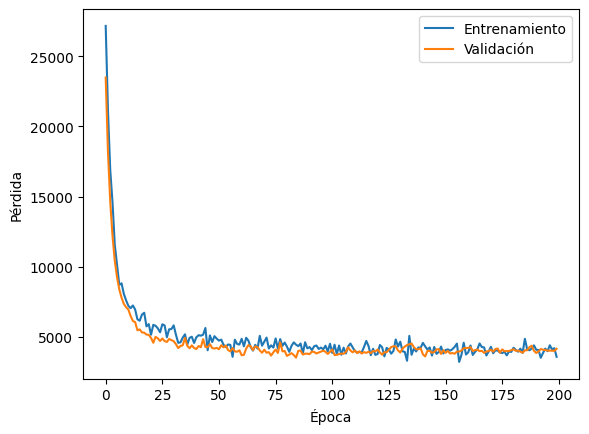

In [75]:
modelo = nn.Sequential(nn.Linear(X_ent.shape[-1], 32),
                       
                       nn.BatchNorm1d(32), 
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(32,16),
                       
                       nn.BatchNorm1d(16), 
                       nn.Sigmoid(),
                       nn.Dropout(0.2),
                       nn.Linear(16, 8),
                       
                       nn.BatchNorm1d(8), 
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(8, 2),

                       nn.BatchNorm1d(2), 
                       nn.Sigmoid(),
                       nn.Dropout(0.2),
                       nn.Linear(2, 1)
                       )

modelo.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo.parameters(), lr = 1e-3)
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt,
               entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Configuración 2
- Más capas ocultas: [64, 128, 64, 32, 16]
- Activación: ELU, LeakyReLU, GELU, SiLU, ReLU
- Regularización: Dropout 0.1, 0.2, 0.3, 0.3, 0.2
- Normalización: GroupNorm después de cada capa oculta

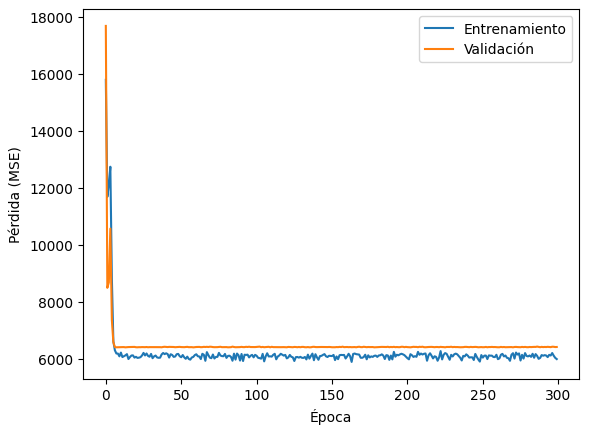

In [76]:
modelo = nn.Sequential(
    nn.Linear(X_ent.shape[-1], 64),
    nn.BatchNorm1d(64),   
    nn.ELU(),        
    nn.Dropout(0.1),

    nn.Linear(64, 128),
    nn.GroupNorm(16, 128), 
    nn.LeakyReLU(),  
    nn.Dropout(0.2),

    nn.Linear(128, 64),
    nn.GroupNorm(8, 64),   
    nn.GELU(),       
    nn.Dropout(0.3),

    nn.Linear(64, 32),
    nn.GroupNorm(8, 32),   
    nn.SiLU(),       
    nn.Dropout(0.3),

    nn.Linear(32, 16),
    nn.GroupNorm(4, 16),   
    nn.ReLU(),       
    nn.Dropout(0.2),

    nn.Linear(16, 1)
)
modelo.to(disp)

ecm = nn.MSELoss()
opt = SGD(modelo.parameters(), lr=1e-3, momentum=0.9)

hist = entrena(modelo, ecm, nn.functional.mse_loss,
               opt, entdl, valdl, n_epocas=300)

plt.plot(hist['perdida_ent']/len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val']/len(valdl), label='Validación')
plt.xlabel('Época'); plt.ylabel('Pérdida (MSE)'); plt.legend(); plt.show()


### Configuración 3
- Más capas ocultas: [d, 10, 20, 1]
- Activación: Sigmoid
- Regularización: Dropout 0.2 despues de cada act
- Normalización: por penalizacion L2, el weight_decay=1e-3

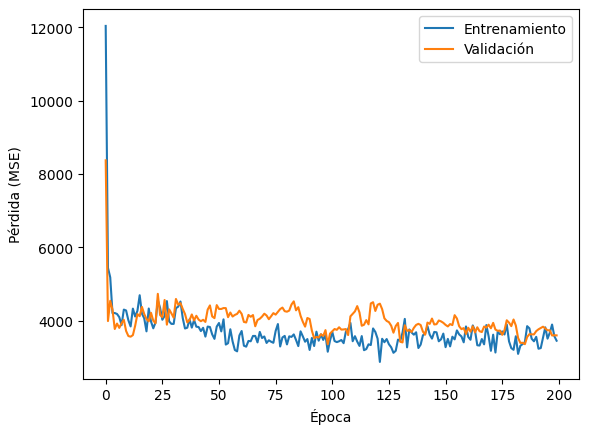

In [ ]:
import torch.nn.functional as F

class Confi3(nn.Module):
    def __init__(self, d_ent, p_drop=0.3):
        super().__init__()
        self.c1 = nn.Linear(d_ent, 10)
        self.c2 = nn.Linear(10, 20)
        self.out = nn.Linear(20, 1)
        self.act = nn.Sigmoid()     
        self.do1 = nn.Dropout(p_drop)
        self.do2 = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.do1(x)            
        x = self.act(self.c2(x))
        x = self.do2(x)
        x = self.out(x)
        return x

modelo = Confi3(X_ent.shape[-1], p_drop=0.3).to(disp)

ecm = nn.MSELoss()
opt = SGD(modelo.parameters(), lr=1e-3, momentum=0.9,
           weight_decay=1e-3)

hist = entrena(modelo, ecm, F.mse_loss,
                opt, entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent']/len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val']/len(valdl), label='Validación')
plt.xlabel('Época'); plt.ylabel('Pérdida (MSE)'); plt.legend(); plt.show()
